# Setup

In [1]:
import warnings
import os
import pathlib
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import json

from sklearn import metrics

from pmdarima.model_selection import train_test_split as time_train_test_split

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance

import lightning.pytorch as pl

warnings.filterwarnings("ignore")

c:\Users\arasyidi\AppData\Local\miniconda3\envs\conda_aqi_forecast\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
%load_ext autoreload
%autoreload 2

from helper_functions import xgb_helper

In [3]:
pl.seed_everything(42)

Global seed set to 42


42

In [4]:
root_dir = pathlib.Path(os.getcwd()).parent
raw_data_dir = root_dir / "data/0_raw"
processed_data_dir = root_dir / "data/1_processed"
experiment_dir = root_dir / "experiment"
secret_dir = root_dir / "secret"

In [10]:
processed_file_name = f"klhk_usable_linearimputed.csv"
processed_file_path = processed_data_dir / processed_file_name

In [30]:
with open(secret_dir/"mlflow_dagshub.json", "r") as f:
    secrets = json.load(f)

# Data Reading

In [11]:
raw_df = pd.read_csv(processed_file_path)
raw_df.head()

,Unnamed: 0,stasiun,pm10,pm2.5,so2,co,o3,no2,hc,pm 2.5 sedang,pm 2.5 tidak sehat,read_time,lin_pm25
0,1992,Bekasi Kayuringin,62.0,96.0,40.0,15.0,45.0,28.0,70.0,55.4,150.4,2023-06-01 00:00:00,96.0
1,1993,Bekasi Kayuringin,62.0,97.0,41.0,15.0,45.0,28.0,70.0,55.4,150.4,2023-06-01 01:00:00,97.0
2,1994,Bekasi Kayuringin,63.0,97.0,42.0,15.0,45.0,28.0,70.0,55.4,150.4,2023-06-01 02:00:00,97.0
3,1995,Bekasi Kayuringin,63.0,98.0,42.0,15.0,45.0,29.0,70.0,55.4,150.4,2023-06-01 03:00:00,98.0
4,1996,Bekasi Kayuringin,62.0,97.0,43.0,15.0,45.0,29.0,70.0,55.4,150.4,2023-06-01 04:00:00,97.0


# Training

## MLPills
https://mlpills.dev/time-series/xgboost-to-forecast-univariate-time-series-data/

In [65]:
filtered_df = raw_df[raw_df['stasiun'] == 'Bekasi Kayuringin'][['read_time','lin_pm25']]
filtered_df = filtered_df.set_index(['read_time'])
# filtered_df = filtered_df.drop(columns=[''])
df_logret = np.log(filtered_df).diff()
df_logret.dropna(inplace=True)

<Axes: xlabel='read_time'>

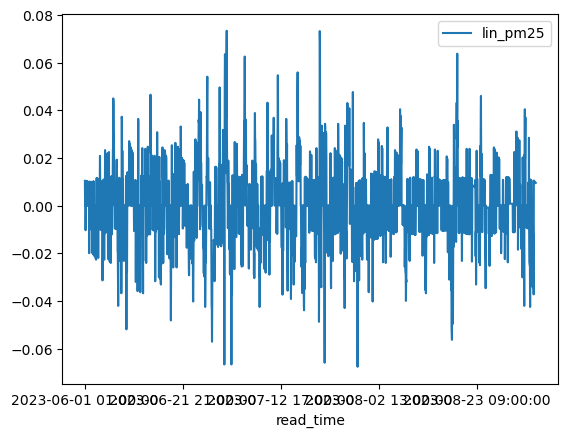

In [66]:
df_logret.plot()

In [67]:
def reframe_to_supervised(df:pd.Series, window_size=7):
    # Initialize empty dataframe
    df_supervised = pd.DataFrame()

    # Define columns names
    X_columns = [f't-{window_size-i}' for i in range(window_size)]
    columns = X_columns + ['target']

    # Iterate
    for i in range(0, df.shape[0] - window_size):
        # Extract the last "window_size" observations and target
        # value and create an individual dataframe with this info
        df_supervised_i = pd.DataFrame([df.values[i:i+window_size+1]],
                                      columns=columns,
                                      index=[df.index[i+window_size]])

        # Add to the final dataframe
        df_supervised = pd.concat((df_supervised, df_supervised_i),
                                   axis=0)

    return df_supervised

In [68]:
df_supervised = reframe_to_supervised(df_logret['lin_pm25'], window_size=7)

In [69]:
df_supervised.head()

,t-7,t-6,t-5,t-4,t-3,t-2,t-1,target
2023-06-01 08:00:00,0.010363,0.000000,0.010257,-0.010257,-0.010363,0.000000,0.000000,0.010363
2023-06-01 09:00:00,0.000000,0.010257,-0.010257,-0.010363,0.000000,0.000000,0.010363,0.000000
2023-06-01 10:00:00,0.010257,-0.010257,-0.010363,0.000000,0.000000,0.010363,0.000000,0.000000
2023-06-01 11:00:00,-0.010257,-0.010363,0.000000,0.000000,0.010363,0.000000,0.000000,0.000000
2023-06-01 12:00:00,-0.010363,0.000000,0.000000,0.010363,0.000000,0.000000,0.000000,0.010257


In [111]:
# Define the proportions for train, validation, and test sets
train_frac = 0.6  # 60% of the data for training
val_frac = 0.2    # 20% for validation
test_frac = 0.2   # 20% for testing

# Calculate the split indices
total_len = len(df_supervised)
train_len = int(total_len * train_frac)
val_len = int(total_len * val_frac)

# Split the DataFrame into train, validation, and test sets
df_train = df_supervised[:train_len]
df_val = df_supervised[train_len:train_len + val_len]
df_test = df_supervised[train_len + val_len:]

In [113]:
# Training set
X_train = df_train.drop(columns=['target'])
y_train = df_train['target']

# validation set
X_val = df_val.drop(columns=['target'])
y_val = df_val['target']

In [114]:
# Convert the datasets into DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val)

# Set XGBoost parameters
param = {
    'max_depth': 3,
    'eta': 0.3,
    'objective': 'reg:squarederror'
}

# Number of boosting rounds
num_round = 100

# Train the model
bst = xgb.train(param, dtrain, num_round)

# Predict the target for the val set
y_pred = bst.predict(dval)

# Calculate and print the RMSE
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"RMSE: {rmse}")

RMSE: 0.012398743038769307


In [120]:
pm_minus_period = filtered_df.copy()

pm_minus_period = pm_minus_period.assign(lin_pm25_prev=pm_minus_period['lin_pm25'].shift(1))
pm_minus_period = pm_minus_period.dropna()

In [117]:
y_pred = pd.DataFrame(data = y_pred, index=y_val.index).rename(columns={0:"lin_pm25_pred"})

In [118]:
# XGBoost forecasted prices
y_pred_prices_xgb = pm_minus_period.lin_pm25_prev * np.exp(y_pred.lin_pm25_pred)
y_pred_prices_xgb = y_pred_prices_xgb.dropna()

<Axes: xlabel='read_time'>

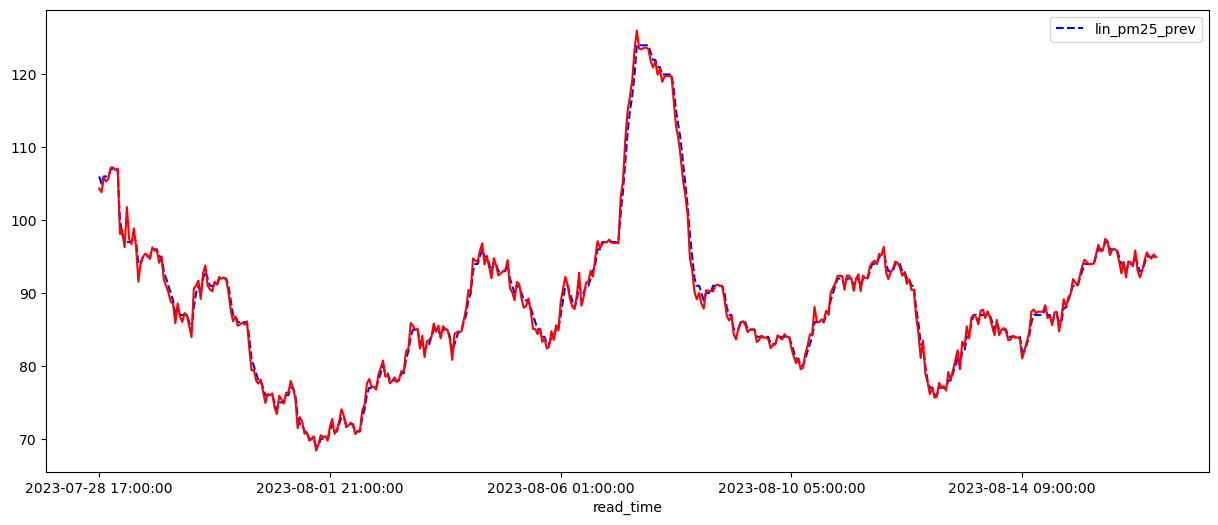

In [119]:
fig, ax = plt.subplots(figsize = (15,6))

pm_minus_period[pm_minus_period.index.isin(y_pred_prices_xgb.index)].drop(columns='lin_pm25').plot(
    ax=ax,
    color='blue',
    style='--',
    label='true value'
)
y_pred_prices_xgb.plot(
    ax=ax,
    color='red',
    label='xgb predicted'
)

In [142]:
# Convert the test_df to a DMatrix, which is the data structure XGBoost uses
test_dmatrix = xgb.DMatrix(df_test.drop(columns=['target']))

# Use the trained model to make predictions on the test data
inference = bst.predict(test_dmatrix)

inference = pd.DataFrame(data = inference, index=y_test.index).rename(columns={0:"lin_pm25_pred"})
inference = pm_minus_period.lin_pm25_prev * np.exp(inference.lin_pm25_pred)
inference = inference.dropna()
inference = pd.DataFrame(inference).rename(columns={0:"lin_pm25_pred"})
inference

,lin_pm25_pred
2023-08-16 20:00:00,94.911122
2023-08-16 21:00:00,93.231414
2023-08-16 22:00:00,93.814238
2023-08-16 23:00:00,95.353132
2023-08-17 00:00:00,96.582424
...,...
2023-09-04 19:00:00,84.143094
2023-09-04 20:00:00,84.955214
2023-09-04 21:00:00,85.883156
2023-09-04 22:00:00,86.718596


In [145]:
result = inference.copy()
true_test_value = pm_minus_period[pm_minus_period.index.isin(inference.index)]['lin_pm25_prev']
result = result.assign(lin_pm25_prev=true_test_value)
result = result.rename(columns={'lin_pm25_prev':'true_values', 'lin_pm25_pred':'predicted_values'})

In [147]:
rmse = np.sqrt(((result['true_values'] - result['predicted_values']) ** 2).mean())
rmse

0.9655073605722597

<Axes: xlabel='read_time'>

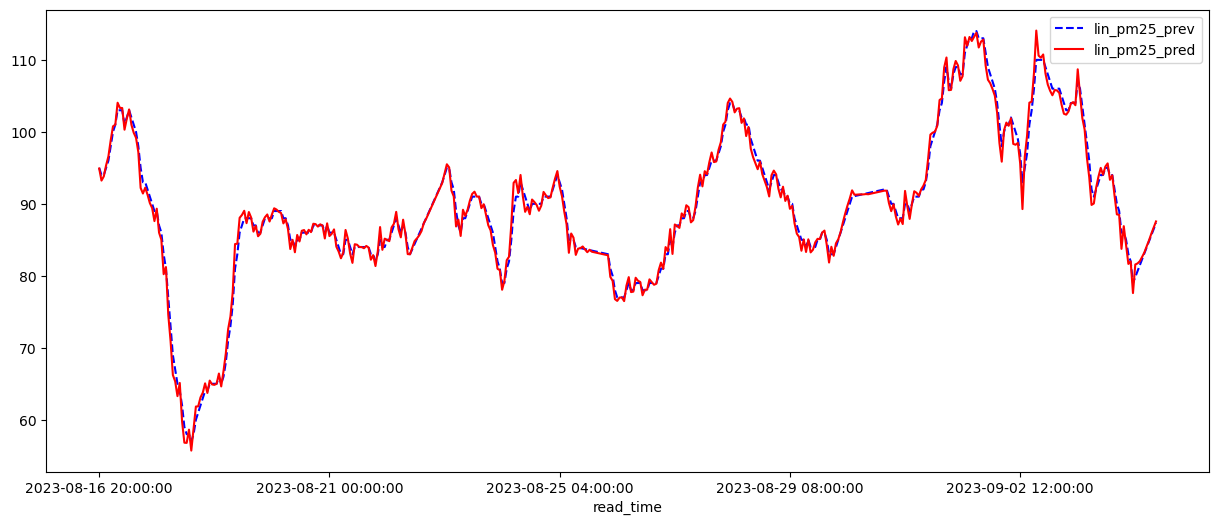

In [141]:
fig, ax = plt.subplots(figsize = (15,6))

pm_minus_period[pm_minus_period.index.isin(inference.index)].drop(columns='lin_pm25').plot(
    ax=ax,
    color='blue',
    style='--',
    label='true value'
)
inference.plot(
    ax=ax,
    color='red',
    label='xgb predicted'
)

## Michael Fuchs
https://michael-fuchs-python.netlify.app/2020/11/10/time-series-analysis-xgboost-for-univariate-time-series/

### Data Preparation

In [12]:
mf_df = raw_df[raw_df['stasiun']=='Bekasi Kayuringin'][['read_time','lin_pm25']]

# Make sure that you have the correct order of the times
mf_df['read_time'] = pd.to_datetime(mf_df['read_time'])
mf_df = mf_df.sort_values(by='read_time', ascending=True)

# Set Datetime as index
mf_df = mf_df.set_index('read_time')
mf_df.head(2)

,lin_pm25
read_time,
2023-06-01 00:00:00,96.0
2023-06-01 01:00:00,97.0


In [13]:
X = mf_df['lin_pm25']

# Test Size = 20%
train_mf_df, test_mf_df = time_train_test_split(X, test_size=int(len(mf_df)*0.2))

train_mf_df = pd.DataFrame(train_mf_df)
test_mf_df = pd.DataFrame(test_mf_df)

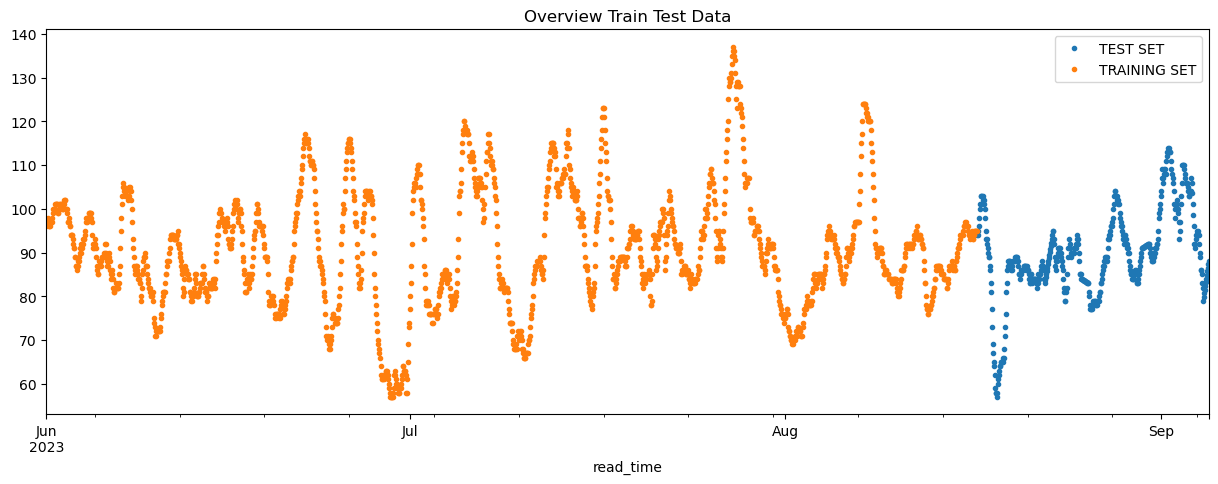

In [14]:
Overview_Train_Test_Data = test_mf_df \
    .rename(columns={'lin_pm25': 'TEST SET'}) \
    .join(train_mf_df.rename(columns={'lin_pm25': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Overview Train Test Data', style='.')

In [16]:
train_mf_df_copy = train_mf_df.copy()
test_mf_df_copy = test_mf_df.copy()

trainX, trainY = xgb_helper.create_features(train_mf_df_copy, target_variable='lin_pm25')
testX, testY = xgb_helper.create_features(test_mf_df_copy, target_variable='lin_pm25')

In [17]:
trainX.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
read_time,,,,,,,,
2023-06-01 00:00:00,0,3,2,6,2023,152,1,22
2023-06-01 01:00:00,1,3,2,6,2023,152,1,22
2023-06-01 02:00:00,2,3,2,6,2023,152,1,22
2023-06-01 03:00:00,3,3,2,6,2023,152,1,22
2023-06-01 04:00:00,4,3,2,6,2023,152,1,22


In [18]:
trainY.head()

read_time
2023-06-01 00:00:00    96.0
2023-06-01 01:00:00    97.0
2023-06-01 02:00:00    97.0
2023-06-01 03:00:00    98.0
2023-06-01 04:00:00    97.0
Name: lin_pm25, dtype: float64

### Baseline model

In [33]:
xgb = XGBRegressor(
        objective='reg:squarederror', 
        n_estimators=1000
)
xgb

xgb.fit(trainX, trainY,
        eval_set=[(trainX, trainY), (testX, testY)],
        early_stopping_rounds=50,
        verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

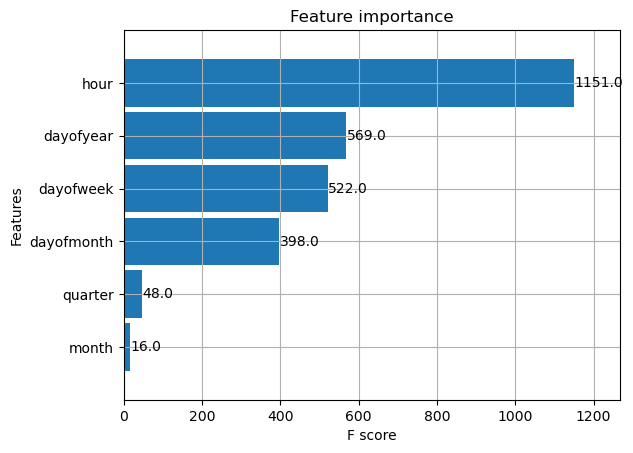

In [34]:
feature_importance = plot_importance(xgb, height=0.9)
feature_importance

In [35]:
predicted_results = xgb.predict(testX)

In [36]:
xgb_helper.timeseries_evaluation_metrics_func(testY, predicted_results)

MSE is : 267.9097434984592
MAE is : 12.472448305560441
RMSE is : 16.36794866495063
MAPE is : 14.073004397948855
R2 is : -1.5050589985010037



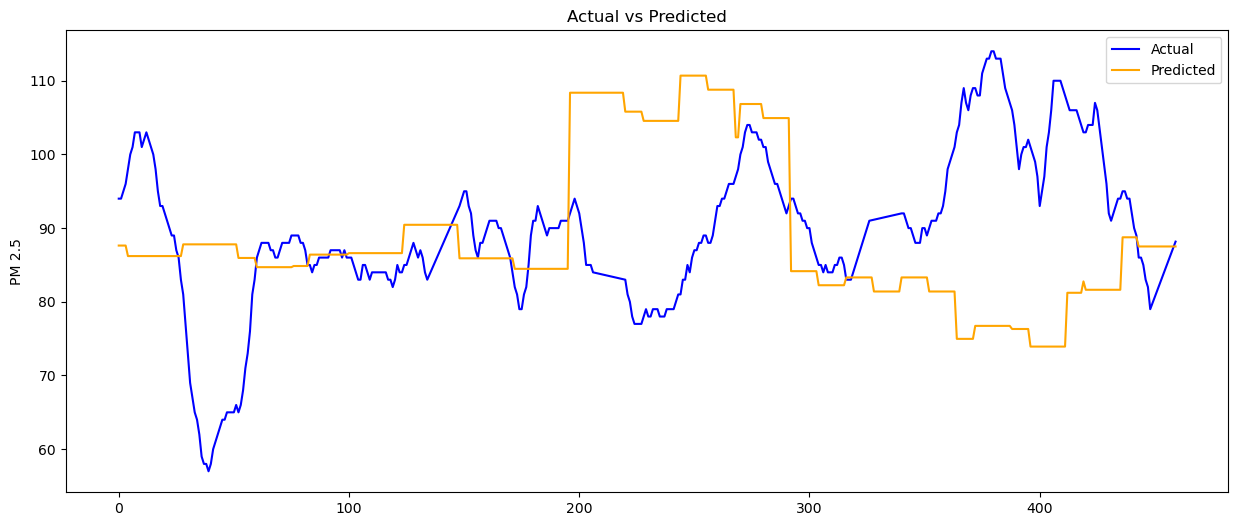

In [39]:
plt.figure(figsize=(15,6))
plt.plot(list(testY), color='blue', label='Actual')
plt.plot(list(predicted_results), color='orange', label='Predicted')
plt.title("Actual vs Predicted")
plt.ylabel("PM 2.5")
plt.legend()
plt.show()

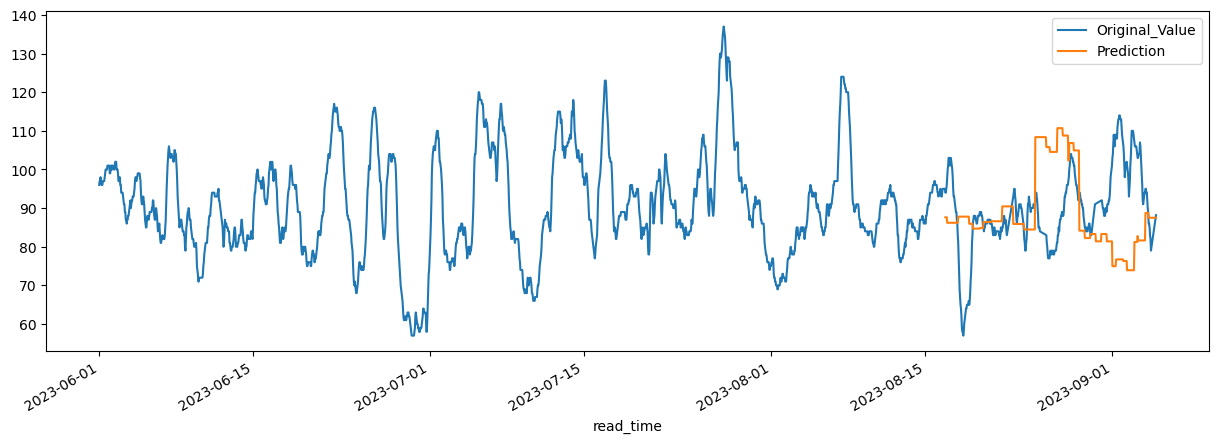

In [40]:
test_mf_df_copy['Prediction'] = predicted_results
pjme_all = pd.concat([test_mf_df_copy, train_mf_df_copy], sort=False)
pjme_all = pjme_all.rename(columns={'lin_pm25':'Original_Value'})

Overview_Complete_Data_And_Prediction = pjme_all[['Original_Value','Prediction']].plot(figsize=(15, 5))

In [41]:
print('Smallest date for which predictions were made: ' )
print(str(test_mf_df_copy.index.min()))

Smallest date for which predictions were made: 
2023-08-16 20:00:00


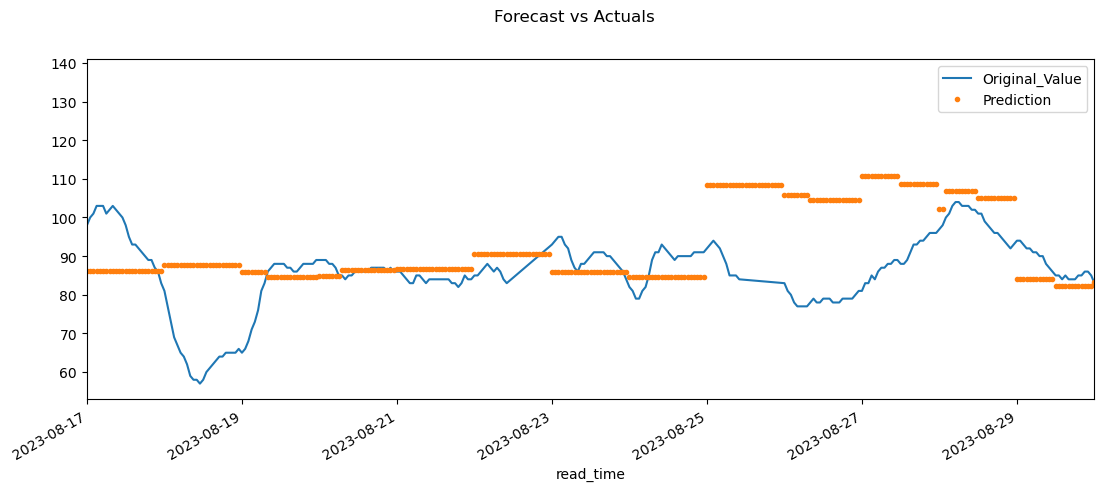

In [43]:
# Plot the forecast with the actuals for Mai
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(13)
Overview_Mai_2015 = pjme_all[['Original_Value', 'Prediction']].plot(ax=ax,
                                                                   style=['-','.'])
ax.set_xbound(lower='2023-08-17', upper='2023-08-30')
# ax.set_ylim(0, 60000)
plot = plt.suptitle('Forecast vs Actuals')

# Experimentation

General Approach for Parameter Tuning
We will use an approach similar to that of GBM here. The various steps to be performed are:

1. Choose a relatively high learning rate. Generally, a learning rate of 0.1 works, but somewhere between 0.05 to 0.3 should work for different problems. Determine the optimum number of trees for this learning rate. XGBoost has a very useful function called “cv” which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.
1. Tune tree-specific parameters ( max_depth, min_child_weight, gamma, subsample, colsample_bytree) for the decided learning rate and the number of trees. Note that we can choose different parameters to define a tree, and I’ll take up an example here.
1. Tune regularization parameters (lambda, alpha) for xgboost, which can help reduce model complexity and enhance performance.
1. Lower the learning rate and decide the optimal parameters.

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [ ]:
# xgb1 = XGBClassifier(
#  learning_rate =0.1,
#  n_estimators=1000,
#  max_depth=5,
#  min_child_weight=1,
#  gamma=0,
#  subsample=0.8,
#  colsample_bytree=0.8,
#  objective= 'binary:logistic',
#  nthread=4,
#  scale_pos_weight=1,
#  seed=27)

In [ ]:
# param_test1 = {
#  'max_depth':range(3,10,2),
#  'min_child_weight':range(1,6,2)
# }

## MLflow

## Data Preparation

In [5]:
root_dir = pathlib.Path(os.getcwd()).parent
raw_data_dir = root_dir / "data/0_raw"
processed_data_dir = root_dir / "data/1_processed"
experiment_dir = root_dir / "experiment"
secret_dir = root_dir / "secret"

In [6]:
processed_file_name = f"klhk_usable_linearimputed.csv"
processed_file_path = processed_data_dir / processed_file_name

raw_df = pd.read_csv(processed_file_path)

In [7]:
filtered_df = raw_df[raw_df['stasiun'] == 'Bekasi Kayuringin'][['read_time','lin_pm25']]

# Make sure that you have the correct order of the times
filtered_df['read_time'] = pd.to_datetime(filtered_df['read_time'])
filtered_df = filtered_df.sort_values(by='read_time', ascending=True)

# Set Datetime as index
filtered_df = filtered_df.set_index(['read_time'])

# convert to log return
period = 168
df_logret = np.log(filtered_df).diff(period)
df_logret.dropna(inplace=True)

In [8]:
def xgb_time_train_test_split(
    all_data:pd.DataFrame,
    train_frac:float,
    val_frac:float,
    test_frac:float
):
    if test_frac:
        assert (
            train_frac+val_frac+test_frac==1, 
            f"train_frac+val_frac+test_frac must equal to 1"
            )
        # Calculate the split indices
        total_len = len(all_data)
        train_len = int(total_len * train_frac)
        val_len = int(total_len * val_frac)
        
        # Split the DataFrame into train, validation, and test sets
        df_train = all_data[:train_len]
        df_val = all_data[train_len:train_len + val_len]
        df_test = all_data[train_len + val_len:]
        
        print(
            f"length of train: {df_train.shape[0]} "
            f"| {round((df_train.shape[0]/total_len)*100)}% of total length\n"
            f"length of validation: {df_val.shape[0]} "
            f"| {round((df_val.shape[0]/total_len)*100)}% of total length\n"
            f"length of test: {df_test.shape[0]} "
            f"| {round((df_test.shape[0]/total_len)*100)}% of total length"
        )
        return df_train, df_val, df_test
    else:
        assert (
            train_frac+val_frac==1,
            f"train_frac+val_frac must equal to 1"
            )
        
        # Calculate the split indices
        total_len = len(all_data)
        train_len = int(total_len * train_frac)
        val_len = int(total_len * val_frac)
        
        # Split the DataFrame into train, validation, and test sets
        df_train = all_data[:train_len]
        df_val = all_data[train_len:]
        
        print(
            f"length of train: {df_train.shape[0]} "
            f"| {round((df_train.shape[0]/total_len)*100)}% of total length\n"
            f"length of validation: {df_val.shape[0]} "
            f"| {round((df_val.shape[0]/total_len)*100)}% of total length\n"
        )
        return df_train, df_val


In [9]:
# Define the proportions for train, validation, and test sets
train_frac = 0.6  # 60% of the data for training
val_frac = 0.2    # 20% for validation
test_frac = 0.2   # 20% for testing

df_train, df_val, df_test = xgb_time_train_test_split(
    df_logret,
    train_frac,
    val_frac,
    test_frac
)

length of train: 1281 | 60% of total length
length of validation: 427 | 20% of total length
length of test: 428 | 20% of total length


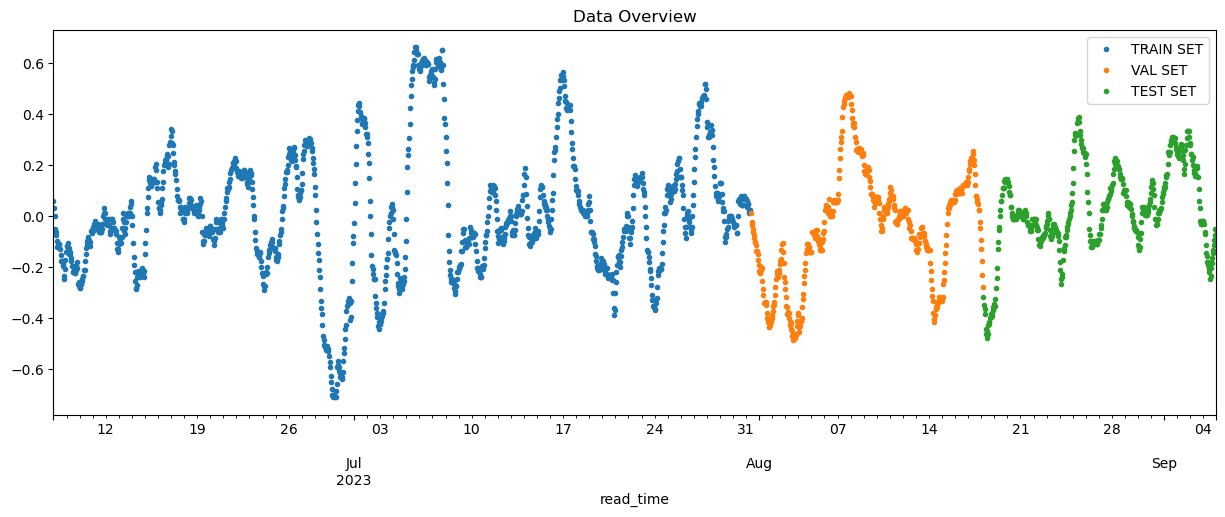

In [11]:
Overview_Data = (
    df_train.rename(columns={'lin_pm25': 'TRAIN SET'})
    .join(df_val.rename(columns={'lin_pm25': 'VAL SET'}), how='outer')
    .join(df_test.rename(columns={'lin_pm25': 'TEST SET'}), how='outer')
    .plot(figsize=(15,5), title='Data Overview', style='.')
)

In [12]:
train_x, train_y = xgb_helper.create_features(df_train, target_variable='lin_pm25')
val_x, val_y = xgb_helper.create_features(df_val, target_variable='lin_pm25')
test_x, test_y = xgb_helper.create_features(df_test, target_variable='lin_pm25')

In [13]:
import mlflow

In [14]:
with open(secret_dir/"mlflow_dagshub.json", "r") as f:
    secrets = json.load(f)

In [15]:
os.environ['MLFLOW_TRACKING_USERNAME'] = secrets['MLFLOW_TRACKING_USERNAME']
os.environ['MLFLOW_TRACKING_PASSWORD'] = secrets['MLFLOW_TRACKING_PASSWORD']
os.environ['MLFLOW_TRACKING_URI'] = secrets['MLFLOW_TRACKING_URI']

In [16]:
# base_exp_name = "xgboost_optuna"
# experiment_name = datetime.now().strftime("%Y%m%d") # returns current date in YYYY-MM-DD format
# experiment_name = experiment_name + "_" + experiment_name

experiment_name = "xgboost_optuna_test"

# Check if the experiment exists, and if not, create it
if not mlflow.get_experiment_by_name(experiment_name):
    mlflow.create_experiment(experiment_name)
experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

# tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

In [17]:
from typing import Dict

In [18]:
def xgb_train(
    train_feature_df:pd.DataFrame,
    train_target_series: pd.Series,
    val_feature_df:pd.DataFrame,
    param:Dict,
    num_round:int
    ):
    # Convert the datasets into DMatrix
    dtrain = xgb.DMatrix(train_feature_df, label=train_target_series)
    dval = xgb.DMatrix(val_feature_df)
    
    # Number of boosting rounds
    num_round = num_round

    # Train the model
    xgb_model = xgb.train(param, dtrain, num_round)

    # Predict the target for the val set
    val_pred = xgb_model.predict(dval)

    # # Calculate and print the RMSE
    rmse = metrics.mean_squared_error(val_y, val_pred)
    return xgb_model, val_pred, rmse

In [19]:
param = {
    'max_depth': 3,
    'eta': 0.05,
    'objective': 'reg:squarederror',
    'subsample': 0.6,
    'colsample_bytree': 0.8,
}

xgb_model, val_pred, rmse = xgb_train(
    train_x, train_y,
    val_x,
    param,
    100
)

In [20]:
def create_delayed_df(
    original_df:pd.DataFrame,
    period:int
):
    # create delayed df
    pm_minus_period = original_df.copy()
    pm_minus_period = pm_minus_period.assign(lagged_value=pm_minus_period['lin_pm25'].shift(period))
    return pm_minus_period.dropna()

pm_minus_period = create_delayed_df(filtered_df, period)

In [51]:
def xgb_predict_plot(
    lagged_df:pd.DataFrame,
    pred_values:np.ndarray,
    true_values:pd.Series,
    value_col_name:str
):  
    # XGBoost forecasted pm
    pred_y_df = pd.DataFrame(
        data=pred_values,
        index=true_values.index).rename(columns={0:"Predicted"})

    y_pred_real = lagged_df.lagged_value * np.exp(pred_y_df.Predicted)
    y_pred_real = y_pred_real.dropna()
    
    fig, ax = plt.subplots(figsize = (15,6))

    y_val_real = (
        lagged_df[lagged_df.index.isin(y_pred_real.index)]
        .drop(columns=value_col_name)
        .reset_index()
    )

    y_val_real.plot(
        x='read_time',
        y='lagged_value',
        ax=ax,
        color='blue',
        label='true value'
    )
    y_pred_real.plot(
        ax=ax,
        color='red',
        style='--',
        label='xgb predicted'
    )

    plt.legend()
    
    return fig, ax, y_val_real, y_pred_real

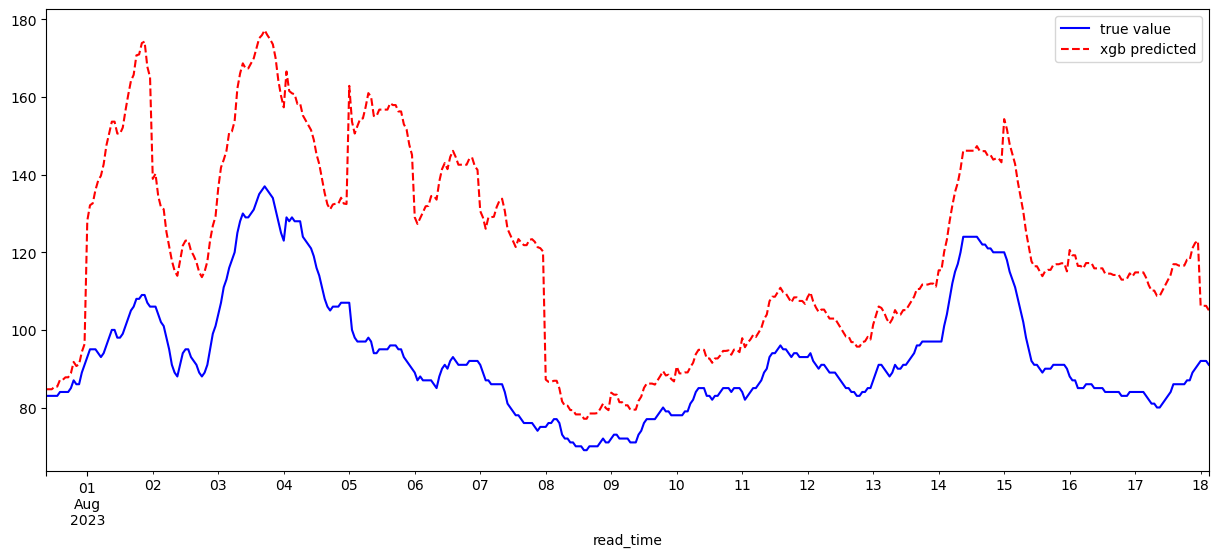

In [52]:
fig, ax, val_y_real, val_pred_real = xgb_predict_plot(
    pm_minus_period,
    val_pred,
    val_y,
    'lin_pm25'
)

In [40]:
dtest = xgb.DMatrix(test_x)

# Predict the target for the val set
test_pred = xgb_model.predict(dtest)

# Calculate and print the RMSE
rmse = metrics.mean_squared_error(test_y, test_pred)
print(f"RMSE: {rmse}")

RMSE: 0.04529599952436396


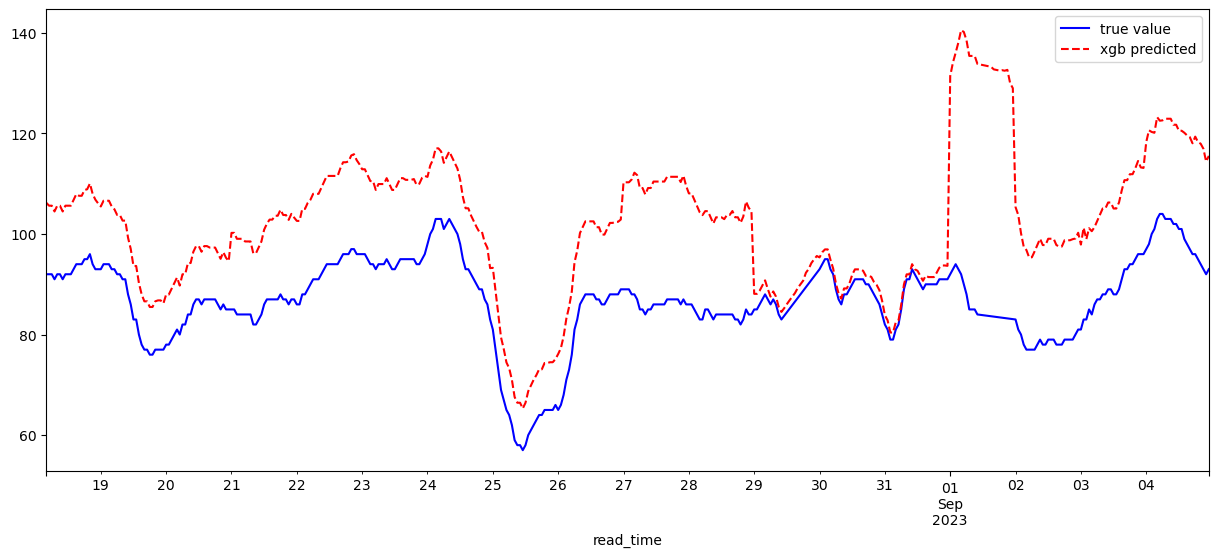

In [53]:
fig, ax, y_test_real, test_pred_real = xgb_predict_plot(
    pm_minus_period,
    test_pred,
    test_y,
    'lin_pm25'
)

In [62]:
np.sqrt(metrics.mean_squared_error(y_test_real.set_index('read_time'), test_pred_real))

18.475606415975626

In [ ]:
# enable auto logging
mlflow.xgboost.autolog()

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

with mlflow.start_run():
    # train model
    params = {
        "objective": "multi:softprob",
        "num_class": 3,
        "learning_rate": args.learning_rate,
        "eval_metric": "mlogloss",
        "colsample_bytree": args.colsample_bytree,
        "subsample": args.subsample,
        "seed": 42,
    }
    model = xgb.train(params, dtrain, evals=[(dtrain, "train")])

    # evaluate model
    y_proba = model.predict(dtest)
    y_pred = y_proba.argmax(axis=1)
    loss = log_loss(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)

    # log metrics
    mlflow.log_metrics({"log_loss": loss, "accuracy": acc})

In [ ]:
def suggest_hyperparameters(trial):
    # Learning rate on a logarithmic scale
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    # Dropout ratio in the range from 0.0 to 0.9 with step size 0.1
    dropout = trial.suggest_float("dropout", 0.0, 0.9, step=0.1)
    # Optimizer to use as categorical value
    optimizer_name = trial.suggest_categorical("optimizer_name", ["Adam", "Adadelta"])

    return lr, dropout, optimizer_name

lr, dropout, optimizer_name = suggest_hyperparameters(trial)
mlflow.log_params(trial.params)

def objective(trial):
    # Initialize the best_val_loss value
    best_val_loss = float('Inf')
    
    # Start a new mlflow run
    with mlflow.start_run():
        # Get hyperparameter suggestions created by Optuna and log them as params using mlflow
        lr, dropout, optimizer_name = suggest_hyperparameters(trial)
        mlflow.log_params(trial.params)

        # Use CUDA if GPU is available and log device as param using mlflow
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        mlflow.log_param("device", device)

        # Initialize network
        model = Net(dropout=dropout).to(device)

        # Pick an optimizer based on Optuna's parameter suggestion
        if optimizer_name == "Adam":
            optimizer = optim.Adam(model.parameters(), lr=lr)
        if optimizer_name == "Adadelta":
            optimizer = optim.Adadelta(model.parameters(), lr=lr)
        scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
        
        # Get DataLoaders for MNIST train and validation set
        train_loader, val_loader = get_mnist_dataloaders()
        
        # Network training & validation loop
        for epoch in range(0, 5):
            avg_train_loss = train(model, device, train_loader, optimizer, epoch)
            avg_val_loss = validate(model, device, val_loader)
            
            if avg_val_loss <= best_val_loss:
                best_val_loss = avg_val_loss

            # Log average train and validation set loss metrics for the current epoch using mlflow
            mlflow.log_metric("avg_train_losses", avg_train_loss, step=epoch)
            mlflow.log_metric("avg_val_loss", avg_val_loss, step=epoch)
            
            scheduler.step()

    # Return the best validation loss achieved by the network.
    # This is needed as Optuna needs to know how the suggested hyperparameters are influencing the network loss.
    return best_val_loss

def main():
    # Create the optuna study which shares the experiment name
    study = optuna.create_study(study_name="pytorch-mlflow-optuna", direction="minimize")
    study.optimize(objective, n_trials=5)

    # Print optuna study statistics
    print("\n++++++++++++++++++++++++++++++++++\n")
    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Trial number: ", trial.number)
    print("  Loss (trial value): ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

In [ ]:
import optuna
from optuna.integration.mlflow import MLflowCallback


def objective(trial):
    x = trial.suggest_float("x", -10, 10)
    return (x - 2) ** 2


mlflc = MLflowCallback(
    tracking_uri=YOUR_TRACKING_URI,
    metric_name="my metric score",
)

study = optuna.create_study(study_name="my_study")
study.optimize(objective, n_trials=10, callbacks=[mlflc])

In [ ]:
import optuna
import mlflow
from optuna.integration.mlflow import MLflowCallback

mlflc = MLflowCallback(
    tracking_uri=YOUR_TRACKING_URI,
    metric_name="my metric score",
)


@mlflc.track_in_mlflow()
def objective(trial):
    x = trial.suggest_float("x", -10, 10)
    mlflow.log_param("power", 2)
    mlflow.log_metric("base of metric", x - 2)

    return (x - 2) ** 2


study = optuna.create_study(study_name="my_other_study")
study.optimize(objective, n_trials=10, callbacks=[mlflc])